In [1]:
import os
import sys
sys.path.insert(0,"/home/kal/CTCF/modules/")
sys.path.insert(0,"/home/kal/CTCF/mass_CTCF/modules/")

os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Must be before importing keras!
import tf_memory_limit
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import ctcfgen
from convnet import Bias
from keras.models import load_model
import keras.backend as K
import keras
from sklearn.metrics import precision_recall_curve
import ucscgenome
import pandas
from scipy.special import logit, expit


input_window = 256
batch_size = 32
min_pred = 0.5

model_path='/home/kal/CTCF/mass_CTCF/output/20170630_173919/20170630_173919_weights__289_0.95.hdf5'
gen_path='/home/kal/data/ctcfgen_data.hdf5'
out_dir = os.path.dirname(model_path)

true_p_path = '/home/kal/data/true_positives.bed' #regions in chip-seq that had at least one pwm call
false_n_path = '/home/kal/data/false_negatives.bed' #regions in chip-seq without a pwm call
false_p_path = '/home/kal/data/false_positives.bed' #pwm calls that didn't correspond to a peak

genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')

Using TensorFlow backend.


In [2]:
# Import the model params.
model = load_model(model_path, custom_objects={'Bias':Bias})
# load the generator
gen = ctcfgen.CTCFGeneratorhdf5(gen_path)

In [3]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

In [4]:
# get the ctcf peaks predictions
def predict_bed(data_path, model, genome, column_names=None):
    peaks = pandas.read_table(data_path, header=None)
    if column_names == None:
        column_names = 'chr start end'
    peaks.columns = column_names.split()

    half_window = input_window // 2

    def seq_gen():
        done = False
        first = True
        batches = 0
        sequences = 0
        iterations = 0
        while not done:
                for index, row in peaks.iterrows():
                    if first:
                        pad_seq = np.zeros((1,256,4))
                        if row.start < 0:
                            row.start = 0
                        seq = ctcfgen.encode(np.fromstring(genome[row.chr][row.start:row.end].lower(), 
                                                           dtype=np.uint8))
                        if seq.shape != (256,4):
                                print(row.start)
                                print(row.end)
                        pad_seq[0, :seq.shape[0], :seq.shape[1]] = seq
                        batch = pad_seq
                        first = False
                    else:
                        if np.asarray(batch).shape == (32, 256, 4):
                            batches +=1
                            yield np.asarray(batch)
                            pad_seq = np.zeros((1,256,4))
                            if row.start < 0:
                                 row.start = 0
                            seq = ctcfgen.encode(np.fromstring(genome[row.chr][row.start:row.end].lower(), 
                                                           dtype=np.uint8))
                            if seq.shape != (256,4):
                                print(row.start)
                                print(row.end)
                            pad_seq[0, :seq.shape[0], :seq.shape[1]] = seq
                            batch = pad_seq
                        elif len(batch) == 32:
                            print('What in the what?!?')
                            print(batch)
                            print(batch.shape)
                        else:                        
                            pad_seq = np.zeros((1,256,4))
                            if row.start < 0:
                                row.start = 0
                            seq = ctcfgen.encode(np.fromstring(genome[row.chr][row.start:row.end].lower(), 
                                                           dtype=np.uint8))
                            if seq.shape != (256,4):
                                print(row.start)
                                print(row.end)
                            pad_seq[0, :seq.shape[0], :seq.shape[1]] = seq
                            batch = np.append(batch, pad_seq, axis=0)
                    sequences += 1
                    
                print('Batches pulled: ' + str(batches))
                final = np.zeros((batch_size, input_window, 4))
                final[:batch.shape[0],:batch.shape[1]] = batch
                print('Sequences pulled: ' + str(sequences))
                print('Did final')
                yield final
                done = True
            
    g = seq_gen()
    
    preds=[]
    
    print('Expected batch count: ' + str((peaks.shape[0] // batch_size) + (peaks.shape[0] % batch_size > 0)))
    
    for i in range((peaks.shape[0] // batch_size) + (peaks.shape[0] % batch_size > 0)):
        batch = next(g)
        if batch.shape == (32, 256, 4):
            preds.append(model.predict_on_batch(batch))
        else:
            print(batch.shape)

    return preds

In [5]:
def split_bed(file_path, out_path, offset=True):
    with open(file_path, 'r') as infile:
        with open(out_path, 'w') as outfile:
            for line in infile.readlines():
                data = line.split('\t') 
                start = int(data[1])
                stop = int(data[2])
                num_tiles = int((stop-start) / input_window) + ((stop-start) % input_window > 0)
                for idx in range(num_tiles):
                    if offset: 
                        new_data = list(data)
                        if start + idx*input_window - input_window//2 > 0:
                            new_data[1] = str(start + idx*input_window - input_window//2)
                        else:
                            new_data[1] = str(0)
                        new_data[2] = str(start + (idx+1)*input_window - input_window//2)
                        outfile.write('\t'.join(new_data) + '\n')                           
                    new_data = list(data)
                    new_data[1] = str(start + idx*input_window)
                    new_data[2] = str(start + (idx+1)*input_window)
                    outfile.write('\t'.join(new_data) + '\n')               

In [9]:
split_bed('/home/kal/data/mystery_motif/motif_regions.bed', '/home/kal/data/mystery_motif/motif_regions_split.bed')

In [15]:
atac_path = '/home/kal/data/intermediates/split_atac_peaks.bed'

print('File length: ' + str(file_len(atac_path)))
preds = predict_bed(atac_path, model, genome, column_names='chr start end')
print('Number predictions: ' +str(np.asarray(preds).flatten().shape))

File length: 962726
Expected batch count: 30086
0
128
16344
16600
16472
16728
Batches pulled: 30085
Sequences pulled: 962726
Did final
Number predictions: (962752,)


In [ ]:
# get only the predictions we need:
num_samples = file_len(atac_path)
flat_preds = np.asarray(preds).flatten()[:num_samples]

In [ ]:
# write to file
peaks = pandas.read_table(atac_path, header=None)
peaks.columns = 'chr start end'.split()
peaks['mlpreds'] = flat_preds 
#peaks.to_csv(os.path.join('/home/kal/data/', 'split_atac_peaks_ml.bed'), sep='\t', index=False)

In [9]:
# get labels and pwm predictions
peaks = pandas.read_table('/home/kal/data/final_atac.bed', header=None)
peaks.columns = 'chr start end ctcf_label pwm_score ml_preds'.split()

In [8]:
# make a ctcf label column:
labels = []
for index, row in peaks.iterrows():
    labels.append(row['numreads']>0)
    
peaks['ctcf_label'] = labels

KeyError: 'numreads'

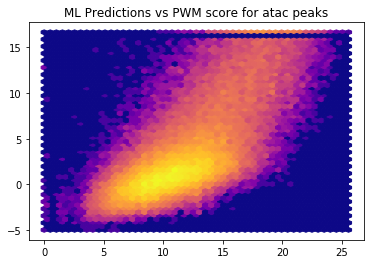

In [14]:
# make a plot of the two precitions vs each other
plt.hexbin(peaks['pwm_score'].tolist(), peaks['ml_preds'].tolist(), gridsize=50, bins='log', cmap='plasma')
plt.title('ML Predictions vs PWM score for atac peaks')
plt.show()

In [11]:
pos_peaks = peaks.loc[peaks['ctcf_label'] == 1]
neg_peaks = peaks.loc[peaks['ctcf_label'] == 0]

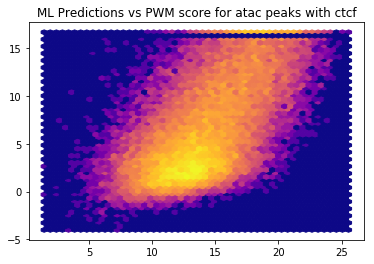

In [15]:
# make a plot of the two precitions vs each other
plt.hexbin(pos_peaks['pwm_score'].tolist(), pos_peaks['ml_preds'].tolist(), gridsize=50, bins='log', cmap='plasma')
plt.title('ML Predictions vs PWM score for atac peaks with ctcf')
plt.show()

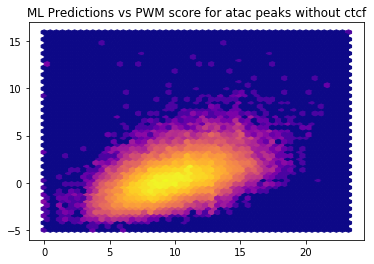

In [16]:
# make a plot of the two precitions vs each other
plt.hexbin(neg_peaks['pwm_score'].tolist(), neg_peaks['ml_preds'].tolist(), gridsize=50, bins='log', cmap='plasma')
plt.title('ML Predictions vs PWM score for atac peaks without ctcf')
plt.show()

In [20]:
print(sum(expit(pos_peaks['ml_preds'].tolist()))/len(pos_peaks['ml_preds'].tolist()))
print(sum(expit(neg_peaks['ml_preds'].tolist()))/len(neg_peaks['ml_preds'].tolist()))

0.938139796512
0.57424011298


In [23]:
deep_precision, deep_recall, thresholds = precision_recall_curve(peaks['ctcf_label'].tolist(), 
                                                                 expit(peaks['ml_preds'].tolist()), pos_label=1)

pwm_precision, pwm_recall, thresholds = precision_recall_curve(peaks['ctcf_label'].tolist(), 
                                                                 peaks['pwm_score'].tolist(), pos_label=1)

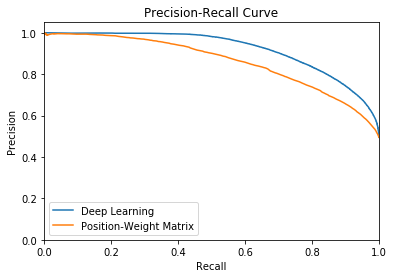

In [24]:
plt.clf()
plt.plot(deep_recall, deep_precision, label='Deep Learning')
plt.plot(pwm_recall, pwm_precision, label = 'Position-Weight Matrix')
plt.legend()
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

In [25]:
# get pr gain
prop_pos = len(pos_peaks)/len(peaks)
print(prop_pos)
deep_precision_gain = [(x-prop_pos)/((1-prop_pos)*x) for x in deep_precision]
deep_recall_gain = [(x-prop_pos)/((1-prop_pos)*x) for x in deep_recall]

pwm_precision_gain = [(x-prop_pos)/((1-prop_pos)*x) for x in pwm_precision]
pwm_recall_gain = [(x-prop_pos)/((1-prop_pos)*x) for x in pwm_recall]

0.4946736218077326


/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars
/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in double_scalars


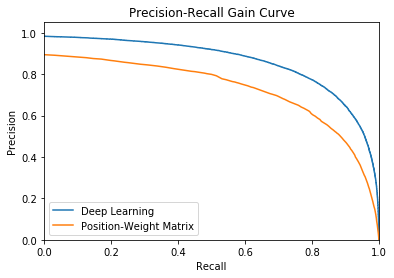

In [26]:
plt.clf()
plt.plot(deep_recall_gain, deep_precision_gain, label='Deep Learning')
plt.plot(pwm_recall_gain, pwm_precision_gain, label = 'Position-Weight Matrix')
plt.legend()
plt.title('Precision-Recall Gain Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

In [57]:
# write out a file with only what we need
finaldf = peaks.filter(['chr', 'start', 'end', 'ctcf_label', 'pwm_score'])
finaldf['ml'] = logit(peaks['ml_preds'])

finaldf.to_csv(os.path.join('/home/kal/data/', 'final_atac.bed'), sep='\t', index=False, header=False)

In [4]:
import subprocess
f = open("/home/kal/data/test.bed", "w")
subprocess.run(['bedtools',  'coverage',  '-a',  '/home/kal/data/intermediates/split_atac_peaks.bed', '-b',  '/home/kal/data/intermediates/chipseq_ctcf_peaks_slopped.bed'], stdout=f)

CompletedProcess(args=['bedtools', 'coverage', '-a', '/home/kal/data/intermediates/split_atac_peaks.bed', '-b', '/home/kal/data/intermediates/chipseq_ctcf_peaks_slopped.bed'], returncode=0)